## Get all data

In [ ]:
import numpy as np
import pandas
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# create a client instance of the library
elastic_client = Elasticsearch(timeout=60, max_retries=10, retry_on_timeout=True)
elastic_client.cluster.health(wait_for_status='yellow', request_timeout=55)

In [ ]:
elastic_docs = []
s = Search(using=elastic_client, index="opensea")
s = s.source(excludes=[
    "last_sale_orginal", "image_original_url", "image_preview_url", "image_url", "os_id",
    'animation_url', '@scraped', 'animation_original_url', 
    'permalink', 'sell_order_usd', 'buy_order_usd'
])

i = 0
for hit in s.scan():
    i += 1
    if i <= 200000: # skip first 200k because of scraped data inconsistencies
        continue
    id = hit.meta.id
    obj = hit.to_dict()
    obj["id"] = id
    elastic_docs.append(obj)

print("documents returned:", len(elastic_docs))

In [ ]:
# create a Pandas DataFrame array from the fields dict
elastic_df = pandas.DataFrame(elastic_docs)

print('elastic_df:', type(elastic_df))

In [72]:
pandas.set_option('max_columns', None)

In [15]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786870 entries, 0 to 1786869
Data columns (total 28 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   creator                  object 
 1   latest_sale_token_value  float64
 2   collection_created       object 
 3   latest_sale_usd          float64
 4   description              object 
 5   is_animation             bool   
 6   @latest_sale_timestamp   object 
 7   external_link            object 
 8   token_id                 object 
 9   name                     object 
 10  collection_slug          object 
 11  collection_description   object 
 12  contract_scheme          object 
 13  latest_sale_token        object 
 14  id                       object 
 15  instagram                object 
 16  twitter                  object 
 17  img_path                 object 
 18  twitter_follower         float64
 19  preview_path             object 
 20  telegram_follower        float64
 21  telegram

In [16]:
del elastic_docs

## Drop columns
Not needed:
- token_id
- external_link

More then 90% NAs:
- telegram_follower
- telegram
- medium_follower
- medium

In [17]:
elastic_df.drop(['token_id', 'external_link'], inplace=True, axis=1)
elastic_df.drop(['telegram_follower', 'telegram', 'medium_follower', 'medium'], inplace=True, axis=1)

In [58]:
elastic_df.drop(['discord_follower', 'discord', 'instagram_follower', 'wikipedia'], inplace=True, axis=1)

In [60]:
elastic_df.drop(['price_crypto'], inplace=True, axis=1)

In [62]:
elastic_df.head()

,creator,sale_usd,description,is_animation,name,collection_name,collection_description,contract_scheme,sale_token,id,...,twitter_follower,preview_path,sale_time,collection_created_year,word_count_coll_desc,unique_asset,instagram_account,twitter_account,z_twitter_follower,z_sale_usd
0,0xb40197806a07b3b2dbb4b43d255ef32c328d44ab,126.311360,A Rug Radio Membership Pass is step one in get...,False,Rug Radio Membership Pass,rug-radio-membership-pass,"[rug, radio, first, fully, decentralize, mediu...",ERC721,ETH,q-sh530Bt_K6OZC-bA85,...,0.0,NaN,11,2021,27,0,0,0,-0.082795,-0.147300
1,WoofpackNFT,76.970985,"WoofPack is a generative NFT collection of , e...",False,Woofpack #1398,woofpacknft,"[freedom, woofpack, adorable, algorithmically,...",ERC721,ETH,e-sh530Bt_K6OZC-XA9q,...,12770.0,C:\nft_data\preview\e-sh530Bt_K6OZC-XA9q_noext...,11,2021,81,0,1,1,-0.039362,-0.151532
2,PudgyPenguinsKing,71.050140,"Lil Pudgys are a collection of , randomly gene...",False,Lil Pudgy #2168,lilpudgys,"[lil, pudgys, collection, randomly, generate, ...",ERC721,ETH,eesh530Bt_K6OZC-XA9U,...,47722.0,C:\nft_data\preview\eesh530Bt_K6OZC-XA9U_noext...,11,2021,24,0,0,1,0.079516,-0.152040
3,0x4fe4e666be5752f1fdd210f4ab5de2cc26e3e0e8,193.414270,"raisingcapital. eth, an ENS name.",False,raisingcapital.eth,ens,"[ethereum, name, service, en, domain, secure, ...",ERC721,ETH,fush530Bt_K6OZC-Xw8O,...,137809.0,NaN,11,2019,36,0,0,1,0.385920,-0.141545
4,CryptoRastas_Team,78.944600,Cryptorasta Shannon Stone is a doctor from New...,False,Cryptorasta #04798,cryptorastas-collection,"[nft, collection, reggae, culture, info, crypt...",ERC721,ETH,hush530Bt_K6OZC-Xw_b,...,5648.0,C:\nft_data\preview\hush530Bt_K6OZC-Xw_b_noext...,11,2021,10,0,1,1,-0.063585,-0.151363


Some rows didn't have the infomation about their price. The reson could be lay either on Opensea or creators or transfars without money invovment. Due to the small amount of such cases I decided to drop them too.

## Renaming

In [24]:
elastic_df = elastic_df.rename(columns={'latest_sale_token':'sale_token'})
elastic_df = elastic_df.rename(columns={'latest_sale_token_value':'price_crypto'})
elastic_df = elastic_df.rename(columns={'latest_sale_usd':'sale_usd'})
elastic_df = elastic_df.rename(columns={'collection_slug':'collection_name'})

In [73]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761754 entries, 0 to 1761753
Data columns (total 25 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   creator                  category
 1   sale_usd                 float64 
 2   description              object  
 3   is_animation             bool    
 4   name                     category
 5   collection_name          object  
 6   collection_description   object  
 7   contract_scheme          category
 8   sale_token               object  
 9   id                       object  
 10  instagram                category
 11  twitter                  category
 12  img_path                 object  
 13  twitter_follower         float64 
 14  preview_path             object  
 15  sale_time                int64   
 16  collection_created_year  int64   
 17  word_count_coll_desc     int64   
 18  unique_asset             int64   
 19  instagram_account        int64   
 20  twitter_account         

## Convert dates and remove missing values

In [27]:
from datetime import datetime

In [28]:
elastic_df = elastic_df[elastic_df['@latest_sale_timestamp'].isna() == False]
elastic_df['sale_time'] = elastic_df.apply(lambda row: datetime.fromisoformat(row['@latest_sale_timestamp']).time().hour, axis=1)
elastic_df.drop(['@latest_sale_timestamp'], inplace=True, axis=1)
elastic_df['collection_created_year'] = elastic_df.apply(lambda row: datetime.fromisoformat(row['collection_created']).year, axis=1)
elastic_df.drop(['collection_created'], inplace=True, axis=1)

## NAs

Empty rows in textual columns

In [29]:
elastic_df['collection_description'].fillna("", inplace = True)

In [30]:
def descriptionFill(row):
    if row['description'] == None:
        return row['collection_description']
    else:
        return row['description']

elastic_df['description'] = elastic_df.apply(lambda row : descriptionFill(row), axis = 1)

In [31]:
elastic_df['creator'].fillna("", inplace = True)
elastic_df['sale_token'].fillna("", inplace = True)
elastic_df['name'].fillna("", inplace = True)
elastic_df['instagram'].fillna("", inplace = True)
elastic_df['twitter_follower'] = elastic_df['twitter_follower'].fillna(0)
elastic_df['twitter'].fillna("", inplace = True)

Remove rows with NAs for cols we absolutely need

In [20]:
elastic_df = elastic_df[elastic_df['sale_usd'].isna() == False]

check if we have an image for every row

In [104]:
from PIL import Image
import os

In [123]:
images_missing = 0

def get_image_path(row):
    global images_missing

    img_path = []
    preview = row['preview_path']
    if preview != None and pandas.isna(preview) == False and preview.startswith('/scraper/data/preview/'):
        img_path.append(os.path.join(os.sep, 'C:' + os.sep, 'nft_data', 'preview', preview[len('/scraper/data/preview/'):]))

    id = row['id']
    image_folder = '..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'
    img_path.append(image_folder + 'preview\\' + id + '_noext.png')
    img_path.append(image_folder + 'img\\' + id + '_noext.png')
    orginal = row['img_path']
    if orginal != None and pandas.isna(orginal) == False:
        img_path.append(orginal)
        if orginal.count('\\') > 0:
            img_path.append(image_folder + 'img\\' + orginal[orginal.rindex('\\') + 1:])

    final_path = None
    for path in img_path:
        if os.path.exists(path):
            final_path = path
            break
    if final_path == None:
        images_missing += 1
        return None

    return final_path

In [124]:
elastic_df['image_path'] = elastic_df.apply(get_image_path, axis=1)
elastic_df = elastic_df[elastic_df['image_path'].isna() == False]
print('removed because of images missing:', images_missing)

removed because of images missing: 587454


In [134]:
len_before = len(elastic_df)
elastic_df = elastic_df[elastic_df['contract_scheme'].isna() == False]
len_after = len(elastic_df)
print('removed because of missing contract scheme:', len_before - len_after)

removed because of missing contract scheme: 25504


In [135]:
elastic_df = elastic_df.reset_index(drop=True)

## Cleaning

In [32]:
elastic_df['twitter'] = elastic_df['twitter'].apply(lambda url: url.replace('https://cdn.syndication.twimg.com/widgets/followbutton/info.json?screen_names=',''))

In [35]:
import re

In [36]:
#remove everything except characters and white spaces.
def clean_text(text):
    # matches: www.gg-io.lkl?q=tz#jjk + opensea.io/collection/ape123 + medium.com/cryptopoop + sub.domain.org
    clean_link = re.compile(r'(^|\s)(https?:\/\/)?(www\.)?[\w\-\.]+\.(com|io|eth|org|gg|de)(\/[\w\.\-\/#\?\=]*)?(\s|$)')
    clean_files = re.compile('[\w-]*\.(png|jpg|tif|obj|svg|gif|js|jpeg)')
    clean = re.compile('[^a-zA-Z \.,\?!:]+')
    clean_missingspace = re.compile('(\w)\.(\w)')
    clean_doublespace = re.compile('\s\s+')
    clean_puncts = re.compile('\.\.+')
    clean_text = re.sub(clean_link, ' ', text)
    clean_text = re.sub(clean_files, '', clean_text)
    clean_text = re.sub(clean, ' ', clean_text)
    clean_text = re.sub(clean_missingspace, '\\1. \\2', clean_text)
    clean_text = re.sub(clean_puncts, '.', clean_text)
    clean_text = re.sub(clean_missingspace, '\\1. \\2', clean_text)
    clean_text = re.sub(clean_doublespace, ' ', clean_text)

    return clean_text

In [37]:
elastic_df['collection_description'] = elastic_df['collection_description'].apply(lambda text: clean_text(text))
elastic_df['description'] = elastic_df['description'].apply(lambda text: clean_text(text))

In [38]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
from time import time

In [41]:
from lemmatization import lemma_text
from multiprocessing import cpu_count, Pool

In [42]:
if __name__ ==  '__main__': 
    t = time()
    pool = Pool(cpu_count() - 4)
    elastic_df['collection_description'] = pool.map(lemma_text, elastic_df['collection_description'])
    print(elastic_df['collection_description'].head(5))
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))

0    [rug, radio, first, fully, decentralize, mediu...
1    [freedom, woofpack, adorable, algorithmically,...
2    [lil, pudgys, collection, randomly, generate, ...
3    [ethereum, name, service, en, domain, secure, ...
4    [nft, collection, reggae, culture, info, crypt...
Name: collection_description, dtype: object
Time: 17.85 mins


## Feature creation

In [43]:
elastic_df['word_count_coll_desc'] = elastic_df["collection_description"].apply(lambda x: len(str(x).split(" ")))

In [44]:
#unique name = 1/yes (as a rule unique asset has a unique name without numbers or collection's name).
#not unique name = 0/no
def unique_name(row):
    if row['name'] == None or row['name'] == "": #all missing values are 0, because these names aren't unique
        return 0
    search_number = re.search('#[0-9]', row['name']) #all names with #1234 are also not unique
    if search_number != None:
        return 0
    search_number = re.search('^[0-9]+$', row['name']) #all names with 1234 are also not unique
    if search_number != None:
        return 0
    #comparison of the name of an asset & collection's name. First we need to prepare the text 
    lowercase = row['name'].lower()
    minus = re.compile('[^a-zA-Z]|official')
    minus_case = re.sub(minus, '', lowercase)
    if row['collection_name'] != None:
        slug = row['collection_name'].lower()
        slug_clean = re.sub(minus, '', lowercase)
        if len(slug_clean) > 0 and slug_clean == minus_case:
            return 0
    print(row['collection_name'], row['name'], minus_case)    
    return 1 

elastic_df['unique_asset'] = elastic_df.apply(lambda row : unique_name(row), axis = 1)

inbetweeners #🧸 
n-e-o-n-v-i-b-e ネオン 377 
inbetweeners #🧸 
inbetweeners #🧸 
yat 💎🆚🦍 
inbetweeners #🧸 
inbetweeners #🧸 
kimo-animals キショ鳥 
inbetweeners #🧸 
inbetweeners #🧸 
inbetweeners #🧸 
inbetweeners #🧸 
manganiku-japan オシャレ肉 
yat 💯🙌💯 
n-e-o-n-v-i-b-e ネオン 55 
ghost-kidz 11:11  
cryptovoxels 31 이문로 
saintj10 區塊鏈 
eponym 🍆💦🍑 
tide-estates 月へ戻って 
decentraland 😎 
n-e-o-n-v-i-b-e ネオン 183 
n-e-o-n-v-i-b-e ネオン 16 
typical-tigers # 27 
salviadroid 💤 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
ptcolorgraphs  🏛️ 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
ptcolorgraphs 🌿🥊 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-sloth-society-by-zzz-labs #??? 
sleepy-

In [45]:
# instagram account? yes - 1, no -0
def instAcc(row):
    insta = row['instagram']
    if isinstance(insta, str) and len(insta) > 0:
        return 1
    else:
        return 0
        
elastic_df['instagram_account'] = elastic_df.apply(lambda row : instAcc(row), axis = 1)

In [46]:
#account? yes - 1, no -0
def twitterAcc(row):
    twitt = row['twitter']
    if isinstance(twitt, str) and len(twitt) > 0:
        return 1
    else:
        return 0
        
elastic_df['twitter_account'] = elastic_df.apply(lambda row : twitterAcc(row), axis = 1)

## Categories

In [47]:
elastic_df['contract_scheme'] = elastic_df['contract_scheme'].astype('category')
elastic_df['name'] = elastic_df['name'].astype('category')
elastic_df['creator'] = elastic_df['creator'].astype('category')
elastic_df['instagram'] = elastic_df['instagram'].astype('category')
elastic_df['twitter'] = elastic_df['twitter'].astype('category')

In [85]:
elastic_df['is_animation'] = elastic_df['is_animation'].astype('category')
elastic_df['collection_name'] = elastic_df['collection_name'].astype('category')
elastic_df['sale_token'] = elastic_df['sale_token'].astype('category')
elastic_df['collection_created_year'] = elastic_df['collection_created_year'].astype('category')
elastic_df['unique_asset'] = elastic_df['unique_asset'].astype('category')
elastic_df['instagram_account'] = elastic_df['instagram_account'].astype('category')
elastic_df['twitter_account'] = elastic_df['twitter_account'].astype('category')

## z-score for outlier

In [49]:
from scipy import stats

twitter_follower

In [50]:
elastic_df['z_twitter_follower'] = stats.zscore(elastic_df['twitter_follower'])

In [53]:
threshold = 3
len_before = len(elastic_df)
elastic_df = elastic_df[elastic_df['z_twitter_follower'].abs() <= threshold]
len_after = len(elastic_df)
print(len_before - len_after)

5345


sale_usd

In [54]:
elastic_df['z_sale_usd'] = stats.zscore(elastic_df['sale_usd'])

len_before = len(elastic_df)
elastic_df = elastic_df[elastic_df['z_sale_usd'].abs() <= threshold]
len_after = len(elastic_df)
print(len_before - len_after)

8550


In [56]:
elastic_df = elastic_df.reset_index(drop=True)

## y-binning

In [63]:
max_usd = np.max(elastic_df['sale_usd']) + 1 # added 1 because sometimes the max value was not bined
print(f'Max price: {max_usd}')

Max price: 36819.9775


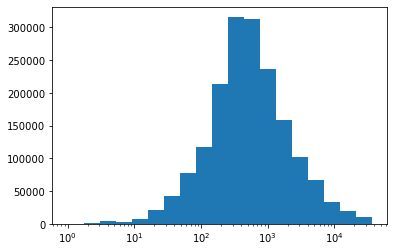

In [64]:
plt.hist(elastic_df['sale_usd'], bins = np.logspace(start = np.log10(1), stop = np.log10(max_usd), num = 20))
plt.gca().set_xscale("log")
plt.show()

In [65]:
bins = np.logspace(start = np.log10(1), stop = np.log10(max_usd), num = 20)
bins

array([1.00000000e+00, 1.73908250e+00, 3.02440795e+00, 5.25969494e+00,
       9.14704342e+00, 1.59074632e+01, 2.76643908e+01, 4.81106580e+01,
       8.36684034e+01, 1.45506256e+02, 2.53047384e+02, 4.40070278e+02,
       7.65318519e+02, 1.33095204e+03, 2.31463541e+03, 4.02534194e+03,
       7.00040173e+03, 1.21742761e+04, 2.11720706e+04, 3.68199775e+04])

In [66]:
def bin_number(price):
    for i in range(0, len(bins)):
        start = 0 - 0.01
        if i > 0:
            start = bins[i-1]
        end = bins[i]
        if price > start and price <= end:
            return int(i) 
        
elastic_df['bin_log_usd'] = elastic_df['sale_usd'].apply(bin_number)

In [67]:
bin_labels = []
for i in range(0, len(bins)):
    start = 0
    if i > 0:
        start = bins[i-1]
    end = bins[i]
    s = '{:.1f}'.format(start)
    e = '{:.1f}'.format(end)
    bin_labels.append(f'{s}-{e}')
bin_labels

['0.0-1.0',
 '1.0-1.7',
 '1.7-3.0',
 '3.0-5.3',
 '5.3-9.1',
 '9.1-15.9',
 '15.9-27.7',
 '27.7-48.1',
 '48.1-83.7',
 '83.7-145.5',
 '145.5-253.0',
 '253.0-440.1',
 '440.1-765.3',
 '765.3-1331.0',
 '1331.0-2314.6',
 '2314.6-4025.3',
 '4025.3-7000.4',
 '7000.4-12174.3',
 '12174.3-21172.1',
 '21172.1-36820.0']

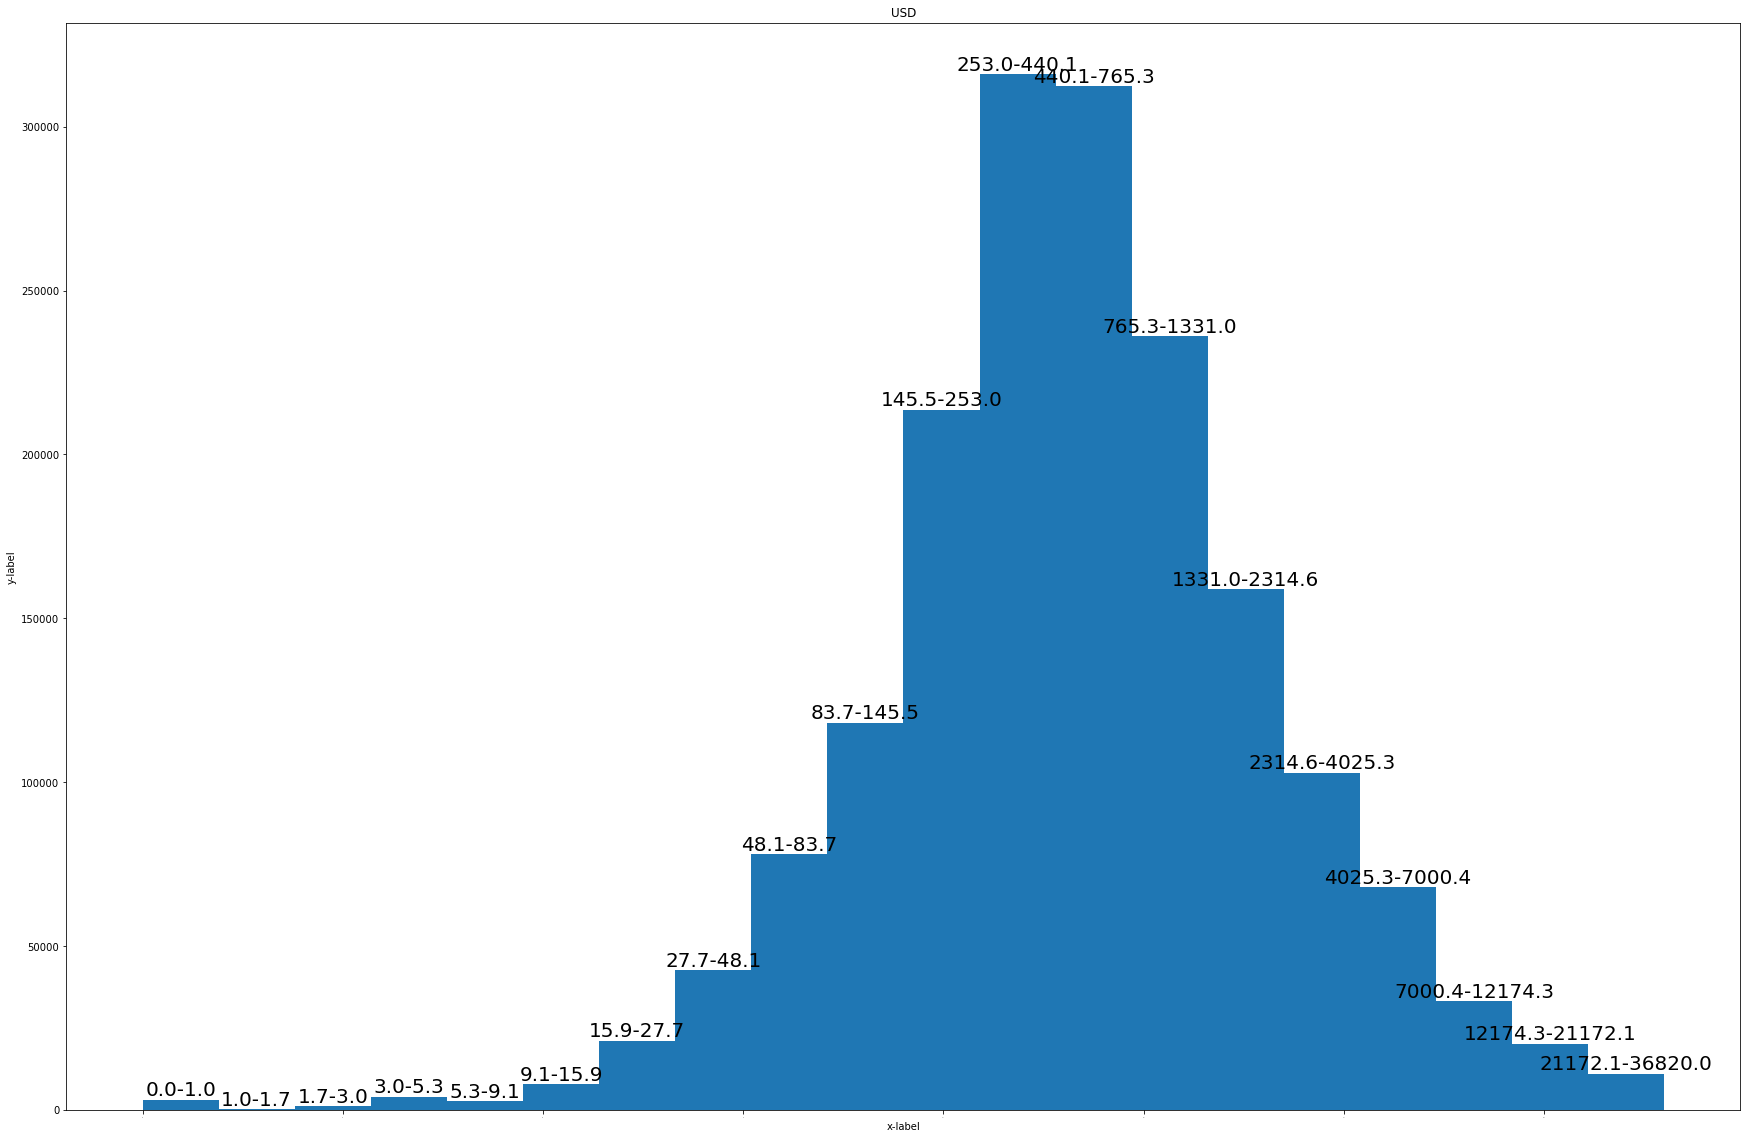

In [68]:
# Creating histogram
fig, ax = plt.subplots(1, 1, figsize=(30,20))
ax.hist(elastic_df['bin_log_usd'], bins=len(bin_labels), align='mid')
# Set title
ax.set_title("USD")
# adding labels
ax.set_xlabel('x-label')
ax.set_ylabel('y-label')
# Make some labels.

#range(len(bin_labels)
rects = ax.patches
for rect, label in zip(rects, bin_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=20)
plt.xticks(fontsize=0)
# Show plot
plt.show()

In [69]:
elastic_df['cat_usd'] = elastic_df['bin_log_usd'].astype('category')

In [70]:
idx_to_class = {
    idx: class_
    for idx, class_ in enumerate(bin_labels)
}
class_to_idx = {bin_labels[i]: i for i in range(len(bin_labels))}

class_to_idx

{'0.0-1.0': 0,
 '1.0-1.7': 1,
 '1.7-3.0': 2,
 '3.0-5.3': 3,
 '5.3-9.1': 4,
 '9.1-15.9': 5,
 '15.9-27.7': 6,
 '27.7-48.1': 7,
 '48.1-83.7': 8,
 '83.7-145.5': 9,
 '145.5-253.0': 10,
 '253.0-440.1': 11,
 '440.1-765.3': 12,
 '765.3-1331.0': 13,
 '1331.0-2314.6': 14,
 '2314.6-4025.3': 15,
 '4025.3-7000.4': 16,
 '7000.4-12174.3': 17,
 '12174.3-21172.1': 18,
 '21172.1-36820.0': 19}

## Cat and num prep

In [74]:
elastic_df.columns.tolist()

['creator',
 'sale_usd',
 'description',
 'is_animation',
 'name',
 'collection_name',
 'collection_description',
 'contract_scheme',
 'sale_token',
 'id',
 'instagram',
 'twitter',
 'img_path',
 'twitter_follower',
 'preview_path',
 'sale_time',
 'collection_created_year',
 'word_count_coll_desc',
 'unique_asset',
 'instagram_account',
 'twitter_account',
 'z_twitter_follower',
 'z_sale_usd',
 'bin_log_usd',
 'cat_usd']

In [10]:
cat_col = [
    'creator',
    'is_animation',
    'name',
    'collection_name',
    'contract_scheme',
    'sale_token',
    'instagram',
    'twitter',
    'collection_created_year',
    'unique_asset',
    'instagram_account',
    'twitter_account'
]

num_col = [
    'sale_usd',
    'twitter_follower',
    'sale_time',
    'word_count_coll_desc',
    'z_twitter_follower',
    'z_sale_usd',
    
]

In [88]:
from sklearn.preprocessing import MinMaxScaler

In [89]:
scaler = MinMaxScaler()

In [92]:
scaled = scaler.fit_transform(elastic_df[num_col])
for i, col in enumerate(elastic_df[num_col].columns):
    newCol = []
    for ii in range(0, len(scaled)):
        newCol.append(scaled[ii][i])
    elastic_df[col] = newCol
elastic_df

,creator,sale_usd,description,is_animation,name,collection_name,collection_description,contract_scheme,sale_token,id,instagram,twitter,img_path,twitter_follower,preview_path,sale_time,collection_created_year,word_count_coll_desc,unique_asset,instagram_account,twitter_account,z_twitter_follower,z_sale_usd,bin_log_usd,cat_usd
0,0xb40197806a07b3b2dbb4b43d255ef32c328d44ab,0.003431,A Rug Radio Membership Pass is step one in get...,False,Rug Radio Membership Pass,rug-radio-membership-pass,"[rug, radio, first, fully, decentralize, mediu...",ERC721,ETH,q-sh530Bt_K6OZC-bA85,,,NaN,0.000000,NaN,0.478261,2021,0.090909,0,0,0,0.000000,0.003431,9.0,9.0
1,WoofpackNFT,0.002091,"WoofPack is a generative NFT collection of , e...",False,Woofpack #1398,woofpacknft,"[freedom, woofpack, adorable, algorithmically,...",ERC721,ETH,e-sh530Bt_K6OZC-XA9q,freedomwoofpack,freedomwoofpack,C:\nft_data\img\e-sh530Bt_K6OZC-XA9q_noext.png,0.014450,C:\nft_data\preview\e-sh530Bt_K6OZC-XA9q_noext...,0.478261,2021,0.279720,0,1,1,0.014450,0.002091,8.0,8.0
2,PudgyPenguinsKing,0.001930,"Lil Pudgys are a collection of , randomly gene...",False,Lil Pudgy #2168,lilpudgys,"[lil, pudgys, collection, randomly, generate, ...",ERC721,ETH,eesh530Bt_K6OZC-XA9U,,pudgy_penguins,C:\nft_data\img\eesh530Bt_K6OZC-XA9U_noext.png,0.054001,C:\nft_data\preview\eesh530Bt_K6OZC-XA9U_noext...,0.478261,2021,0.080420,0,0,1,0.054001,0.001930,8.0,8.0
3,0x4fe4e666be5752f1fdd210f4ab5de2cc26e3e0e8,0.005253,"raisingcapital. eth, an ENS name.",False,raisingcapital.eth,ens,"[ethereum, name, service, en, domain, secure, ...",ERC721,ETH,fush530Bt_K6OZC-Xw8O,,ensdomains,C:\nft_data\img\fush530Bt_K6OZC-Xw8O.svg,0.155942,NaN,0.478261,2019,0.122378,0,0,1,0.155942,0.005253,10.0,10.0
4,CryptoRastas_Team,0.002144,Cryptorasta Shannon Stone is a doctor from New...,False,Cryptorasta #04798,cryptorastas-collection,"[nft, collection, reggae, culture, info, crypt...",ERC721,ETH,hush530Bt_K6OZC-Xw_b,cryptorastas,cryptorastas,C:\nft_data\img\hush530Bt_K6OZC-Xw_b_noext.png,0.006391,C:\nft_data\preview\hush530Bt_K6OZC-Xw_b_noext...,0.478261,2021,0.031469,0,1,1,0.006391,0.002144,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761749,Ape1683,0.001371,"Bones Bananas is a collection of , unique, pro...",False,,bones-and-bananas,"[bone, banana, collection, unique, programmati...",ERC721,ETH,bR-ar34B-_EH3z1syssv,,bonesandbananas,/scraper/data/img/bR-ar34B-_EH3z1syssv_noext.png,0.004740,/scraper/data/preview/bR-ar34B-_EH3z1syssv_noe...,0.434783,2021,0.108392,0,0,1,0.004740,0.001371,8.0,8.0
1761750,PrivateJetPyjamaParty,0.170687,Private Jet Pyjama Party,False,#3208,pjpp,"[first, pjpp, collection, create, together, ar...",ERC721,ETH,aR-ar34B-_EH3z1syssP,pjpp.nft/,pjpp_nft,/scraper/data/img/aR-ar34B-_EH3z1syssP_noext.png,0.003209,/scraper/data/preview/aR-ar34B-_EH3z1syssP_noe...,0.434783,2021,0.146853,0,1,1,0.003209,0.170687,16.0,16.0
1761751,0xd3f27738a6ca4ad6201ee934e5fcf3756a46aedb,0.008226,"Persona Lamps is a collection of , LAMP NFTs w...",False,Persona Lamp #611,persona-lamps,"[persona, lamp, collection, lamp, nfts, variat...",ERC721,ETH,ax-ar34B-_EH3z1syssg,,persona_lamps,/scraper/data/img/ax-ar34B-_EH3z1syssg_noext.png,0.001127,/scraper/data/preview/ax-ar34B-_EH3z1syssg_noe...,0.434783,2021,0.136364,0,0,1,0.001127,0.008226,11.0,11.0
1761752,0x07a5dc49c58a4418feb52426601abe556ca55cbe,0.001714,Repeat Offenders is a collection of procedural...,False,Repeat Offender #3381,repeat-offenders,"[repeat, offender, gerhard, human, http, gerha...",ERC721,ETH,Zh-ar34B-_EH3z1sycvj,,,/scraper/data/img/Zh-ar34B-_EH3z1sycvj_noext.png,0.000000,/scraper/data/preview/Zh-ar34B-_EH3z1sycvj_noe...,0.434783,2022,0.087413,0,0,0,0.000000,0.001714,8.0,8.0


## Truncat to top-cat only

In [93]:
def top_cat_values(cat, number):
    #tops = cat.value_counts()[:number].index.tolist()
    tops = cat.value_counts()[:number - 1].index.tolist()
    default_cat = number - 1
    #[f(x) if condition else g(x) for x in sequence]
    arr = [tops.index(x) if x in tops else default_cat for x in cat]
    return pandas.Series(arr).astype('category')

Only limit categories with too much unique values

In [102]:
top_cat_limit = 4096
for col in cat_col:
    if top_cat_limit < len(elastic_df[col].cat.categories):
        elastic_df[col] = top_cat_values(elastic_df[col], top_cat_limit)

## Tensor

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
categorical_column_sizes = [len(elastic_df[column].cat.categories) for column in cat_col]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4096, 50), (2, 1), (4096, 50), (4096, 50), (3, 2), (30, 15), (4096, 50), (4096, 50), (4, 2), (2, 1), (2, 1), (2, 1)]


## Split the data

In [141]:
from sklearn.model_selection import train_test_split

In [144]:
Y = elastic_df.pop('cat_usd')
X = elastic_df

In [145]:
train_size = 0.5

x_train, x_rem, y_train, y_rem = train_test_split(X, Y, train_size = train_size, random_state=69)

# Now since we want the valid and test size to be equal (20% each of overall data). 
# we have to define valid_size = 0.5 (that is 50% of remaining data)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = 0.5, random_state=42)

print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(574398, 25)
(574398,)
(287199, 25)
(287199,)
(287199, 25)
(287199,)


(None, None)

In [151]:
del x_rem, y_rem, elastic_df, X, Y

In [1]:
import pickle

In [3]:
pickle_dir = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\'

In [32]:
def save_pkl(obj, name):
    with open(pickle_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#save_pkl(x_train, 'x_train')
#save_pkl(x_test, 'x_test')
#save_pkl(x_valid, 'x_valid')
save_pkl(y_train, 'y_train')
save_pkl(y_test, 'y_test')
save_pkl(y_valid, 'y_valid')

In [4]:
def load_pickle(name):
    with open(pickle_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)

#x_train = load_pickle('x_train')
#x_test = load_pickle('x_test')
x_valid = load_pickle('x_valid')
#y_train = load_pickle('y_train')
#y_test = load_pickle('y_test')
#y_valid = load_pickle('y_valid')

In [11]:
categorical_column_sizes = [len(x_valid[column].cat.categories) for column in cat_col]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4096, 50), (2, 1), (4096, 50), (4096, 50), (3, 2), (30, 15), (4096, 50), (4096, 50), (4, 2), (2, 1), (2, 1), (2, 1)]


In [13]:
def save_pkl(obj, name):
    with open(pickle_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
save_pkl(categorical_embedding_sizes, 'categorical_embedding_sizes')

In [ ]:
def output_prep(dataframe_y):
    dataframe_y = torch.tensor(dataframe_y).flatten()
    return dataframe_y    

In [4]:
torch.tensor([[1,2,3,4,666]]).flatten()

tensor([  1,   2,   3,   4, 666])

In [31]:
cat = x_valid.iloc[0]['contract_scheme']
cat

'ERC721'

In [32]:
x_valid['contract_scheme'].cat.categories.tolist().index(cat)

2

In [42]:
np.stack([[1,2,3,4,666], [1,2,3,4,666]], 1)

array([[  1,   1],
       [  2,   2],
       [  3,   3],
       [  4,   4],
       [666, 666]])

In [43]:
x_valid['contract_scheme'].cat.codes.values

array([2, 2, 2, ..., 2, 2, 2], dtype=int8)

In [6]:
y_valid = load_pickle('y_valid')

In [26]:
y_train = y_train.fillna(0)

In [28]:
y_train.isna().value_counts()

False    574398
Name: cat_usd, dtype: int64

In [31]:
y_test = y_test.fillna(0)
y_valid = y_valid.fillna(0)

In [1]:
from PIL import Image
from io import BytesIO 
import cairosvg

In [2]:
def get_preview_image(path):
    out = BytesIO()
    cairosvg.svg2png(url=path, write_to=out)
    return Image.open(out).convert('RGB')


In [ ]:
out = BytesIO()
cairosvg.svg2png(url='..\..\opensea_scapper\opensea_nft_scrapper\data\img\WtPC630B7RQ_xL7fyyQV.svg', write_to=out)
Image.open(out).convert('RGB') # x_train['image_path'].iloc[2292]

In [8]:
x_valid['image_path']

453052     C:\nft_data\preview\SGxfR34BklRAyF0RUsg3_noext...
1063738    C:\nft_data\preview\O5g8on4B94eJxbCKghzo_noext...
1061359    C:\nft_data\preview\HpbNoH4B94eJxbCK25tA_noext...
1074393    C:\nft_data\preview\_Jl2o34B94eJxbCKs3hD_noext...
310077     ..\..\opensea_scapper\opensea_nft_scrapper\dat...
                                 ...                        
357787     C:\nft_data\preview\oJgZKH4B_KkDEn3bFJ_i_noext...
79813      ..\..\opensea_scapper\opensea_nft_scrapper\dat...
1044516    C:\nft_data\preview\_kQEc34BsmfSdFj-9ixX_noext...
30472      ..\..\opensea_scapper\opensea_nft_scrapper\dat...
896055     C:\nft_data\preview\q5Rhnn4B94eJxbCKgwvw_noext...
Name: image_path, Length: 287199, dtype: object

In [9]:
path = x_valid['image_path'].iloc[4]
svg = path.endswith('.svg')
if path.startswith('..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'):
    path = path[len('..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'):]
    path = 'E:\\data\\opensea\\' + path

path

'E:\\data\\opensea\\img\\B-P3AH4Br5kyUoyL9HLP_noext.png'